In [1]:
import optuna 
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
import os 
from functools import partial
import ml_collections

CHECKPOINT_PATH = 'experiments/tuning'

/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    config.n_samples=5000
    config.input_steps=1
    config.output_delay=0 # predict 0 hours into the future
    config.output_steps=4
    config.timestep_duration= 3
    config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
    config.time_resolution=120
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=None
    config.max_checkpts_to_keep=None # none means all
    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 100
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPGraphNetwork'
    config.n_blocks = trial.suggest_int('n_blocks', 1, 3)
    config.share_params = False
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.2)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    # config.activation = "leaky_relu"
    
    config.pred_x1 = True
    config.pred_x2 = True

    if config.pred_x1 and config.pred_x2:
        output_layer = 2
    else:
        output_layer = 1

    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 6), 
        output_layer) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict, _ = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    return eval_metrics_dict['val'].compute()['loss']

In [3]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=5000
    config.input_steps=1
    config.output_delay=0 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=None

    return config

In [4]:
def prepare_study(study_name):
    # generate dataset 
    dataset_config = get_data_config()
    datasets = create_dataset(dataset_config)
    
    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

In [5]:
study, objective_partial = prepare_study(study_name="no_edge_test")

[I 2024-07-23 10:54:47,131] A new study created in RDB with name: no_edge_test


In [6]:
study.optimize(objective_partial, 
                n_trials=5-len(study.trials),
                n_jobs=1)

[I 2024-07-23 10:56:18,316] Trial 0 finished with value: 1.5120627880096436 and parameters: {'optimizer': 'adam', 'learning_rate': 2.2829289597155438e-05, 'n_blocks': 1, 'dropout_rate': 0.16650482696538296, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5}. Best is trial 0 with value: 1.5120627880096436.
[I 2024-07-23 10:57:44,110] Trial 1 finished with value: 1.3797012567520142 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00031353866726281686, 'n_blocks': 1, 'dropout_rate': 0.08667482980211638, 'activation': 'relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 5}. Best is trial 1 with value: 1.3797012567520142.
[I 2024-07-23 10:59:23,225] Trial 2 finished with value: 1.4139653444290161 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0002548029248518634, 'momentum': 0.45535402516679613, 'n_blocks': 2, 'dropout_rate': 0.04740872552972933, 'activation': 'relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 2, '

In [7]:
from utils.hyperparam_tuning import get_best_trial_config, get_best_trial_workdir
from utils.jraph_vis import plot_predictions

Checkpoint directory: /Users/miamirabelli/Desktop/GNN Research/lorenzGNN/experiments/tuning/no_edge_test/trial_3/checkpoints


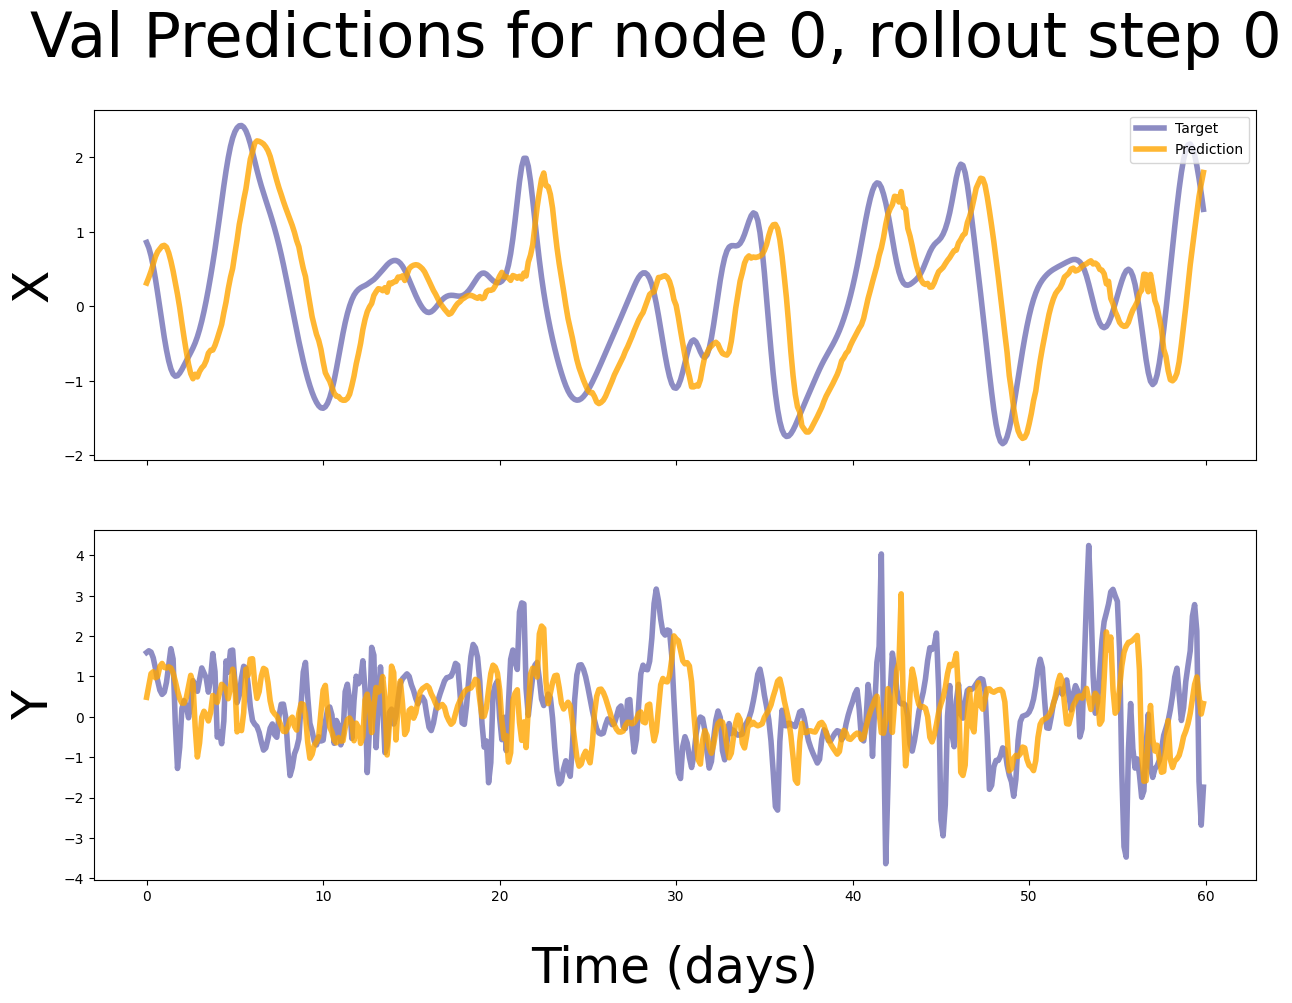

In [8]:
plot_predictions(
    config=get_best_trial_config(study=study),
    workdir=get_best_trial_workdir(study=study), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    plot_days=60,
    title="Val Predictions for node 0, rollout step 0"
)

In [9]:

current = get_best_trial_config(study=study)
print(f"optimizer:", current.optimizer)
print(f"learning rate:", current.learning_rate)
print(f"n blocks:", current.n_blocks)
print(f"dropout rate:", current.dropout_rate)
print(f"activation:", current.activation)
print(f"edge features:", current.edge_features)
print(f"node features:", current.node_features)
print("---------------------------------------")

optimizer: adam
learning rate: 0.0005315432382110867
n blocks: 1
dropout rate: 0.012062872000449067
activation: leaky_relu
edge features: (8, 4)
node features: (64, 2)
---------------------------------------
